In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as mvn
from scipy.stats import multinomial as mlvn
from scipy.stats import bernoulli as brn
# A multivariate normal random variable. Think about a 3 dimensionsal guassian 

%matplotlib inline

In [2]:
# function definition 
def accuracy(y,y_hat):
    return np.mean(y == y_hat)

In [3]:
df = pd.read_csv('xor.csv')

In [4]:
X = df.to_numpy()
y = X[:,-1] # storing just the labels
X = X[:,:-1] # Dropping the the last column, AKA the labels

## Naive Gaussian Bayes

In [5]:
class GaussNB():
        
    def fit(self, X, y, epsilon = 1e-2):
        self.likelihoods = dict() # 
        self.priors = dict() #
        
        self.K = set(y.astype(int)) #
        
        for k in self.K:
            
            X_k  = X[y==k,:] 
            self.likelihoods[k] = {"mean" : X_k.mean(axis=0), "cov": X_k.var(axis = 0) + epsilon } 
            self.priors[k] = len(X_k)/len(X)  #        

    def predictNB(self, X):
        
        N,D = X.shape 
        P_hat = np.zeros((N,len(self.K))) 
        
        for k, l in self.likelihoods.items():
            P_hat[:,k] = mvn.logpdf(X,l["mean"], l["cov"]) + np.log(self.priors[k])
            
        return P_hat.argmax(axis=1) # 
        

## Gaussian Bayes 

In [6]:
class GaussBayes(): # not naive 
    
    
    def fit(self, X, y, epsilon = 1e-2):

        
        self.likihoods = dict() # 
        self.priors = dict() #     
        self.K = set(y.astype(int)) # 
        
        for k in self.K:   
            X_k = X[y==k,:]
            N_k, D = X_k.shape
            mu_k = X_k.mean(axis = 0)
            self.likihoods[k] = {"mean" : X_k.mean(axis=0), "cov": (1/(N_k - 1))*np.matmul((X_k - mu_k).T, X_k - mu_k) + epsilon*np.identity(D) } 
            # when multiplying a matrix by its transpose is what? What does that do
            self.priors[k] = len(X_k)/len(X)  
        
    
    # Now we get to the prediction
    def predictGB(self, X):
        N,D = X.shape # 
        P_hat = np.zeros((N,len(self.K))) # this is a tuple
        
        for k, l in self.likihoods.items(): 
 
            P_hat[:,k] = mvn.logpdf(X,l["mean"], l["cov"]) + np.log(self.priors[k]) # getting a function that gives us the probablity density
            
        return P_hat.argmax(axis=1) # maximum postier estimator

## Bernoulli Bayes 

In [7]:
class BernBayes():
  def fit(self, X, y, epsilon = 1e-3):
    N, D = X.shape
    self.likelihoods = {}
    self.priors = {}
    self.K = set(y.astype(int))

    for k in self.K:
      X_k = X[y==k,:]
      p = (sum(X_k)+1) / (len(X_k)+2)
      self.likelihoods[k] = {'mean': p, 'cov': p * (1 - p) + epsilon}
      self.priors[k] = len(X_k)/len(X)

  def predict(self, X):
    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))

    for k,l in self.likelihoods.items():
      # Using the Bernoulli funtion/formula. Trick is to get the matrices/vectors to go from mxn to a 1x1 number for each k value.
      P_hat[:,k] = np.log(self.priors[k]) + np.matmul(X, np.log(l['mean'])) + np.matmul((1 - X), np.log(abs(1-l['mean'])))

    return P_hat.argmax(axis =1)

## Multinomial Bayes

In [8]:
class GaussMB(): # not naive 
    
    
    def fit(self, X, y, epsilon = 1e-3):

        
        self.likihoods = dict() # 
        self.priors = dict() #     
        self.K = set(y.astype(int)) # 
        
        for k in self.K:
            X_k = X[y == k,:] # All the values in class k
            N_k, D = X_k.shape # N_k number of observations, D is number of features
            mu_k = X_k.mean(axis=0)
                
            N = len(X)
            self.likihoods[k] = {"N" : N, "P" : sum(N_k/len(X))}
            self.priors[k] = len(X_k)/len(X)  
        
    
    # Now we get to the prediction
    def predictMB(self, X):
        N,D = X.shape # 
        P_hat = np.zeros((N, len(self.K)))
            
        for k, l in self.likelihoods.items():
            P_hat[:,k] = mlvn.logpmf(X, l['N'],l['P']) + np.log(self.priors[k])
            #P_hat[:,k] = mvn.logpdf(X, l['N'],l['P']) + np.log(self.priors[k])
        
        return(P_hat.argmax(axis = 1))

## K - Nearest Neighbors

In [9]:
class KNNB():
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predictKNN(self,X, K, epsilon = 1e-3):
        N = len(X) # has no self, this was the X it was given in the parameters, self.X and X are different variables
        y_hat = np.zeros(N)
        
        for i in range(N): # we are going through every single point. So thats a good thing or bad thing
            #   use cases... wanted to find out all the members of a neighborhood 
            #   use cases... have map of the US that is built from lights that satellites can see, and we want to map the cities using that light
            #   use cases... a model that mapped the disbursion of the dieses of the rona using the light map model from satellites 
            dist2 = np.sum((self.X - X[i])**2, axis=1) # by substracting from the ith member of x, we are getting the distance of each
            idxt = np.argsort(dist2)[:K] # going to sort to each based on the distance 
            gamma_K = 1/(np.sqrt(dist2[idxt])+ epsilon) # we add epislon to avoid division by 0
            y_hat[i] =  np.bincount(self.y[idxt], weights = gamma_K).argmax() # we want the smallest gamma_k
            # taking the biggest chunks and summing them
            # getting the probability that 
            # bincount produces the probability
            # the argmax gives the actual value of the class, the maximum class
            # bincount adds chunks, we're getting the distances of the sections we're adding
            # 
        return  y_hat

## Linear Regression

fit = $X^T X$ , $X^T y$ <br>
predict = $X \cdot w$


In [10]:
class LR():
    def fit(self, X,y):
        self.w = np.linalg.solve(X.T@X, X.T @ y) # w is the weights 
    
    def predict(self, X):
        return np.matmul(X, self.w) # matmul is piece-wise
        

In [11]:
lr = LR()


In [12]:
lr.fit(X,y)
y_hat = lr.predict(X)

In [13]:
# function definition 
def accuracy(y,y_hat):
    return np.mean(y == y_hat)

In [14]:
print(f"Accuracy : {accuracy(y,y_hat):0.3f}")

Accuracy : 0.000


## KNN Regressor

In [15]:
class knnr():
    def fit(self, X,y):
        self.X = X
        self.y = y
        
    def predict(self, X,K, epsilon = 1e-3):
        N = len(X)
        
        y_hat = np.zeros(N)
        
        for i in range(N):
            dist2 = np.sum((self.X - X[i])**2, axis =1)
            idxt = np.argsort(dist2)[:K] # the top k's
            gamma_k = np.exp(-dist2[idxt])/np.exp(-dist2[idxt]).sum() # could do it the sum version
            y_hat[i] = gamma_k.dot(self.y[idxt])
            
        return y_hat

In [16]:
class contValDat():
    def create(self, D,N,r=20):
        
        self.X = np.linspace(0,r,N).reshape(N,D)
        self.y = np.sqrt(self.X) + np.exp(-(self.X-5)**2) - 2* (np.exp(-(self.X -12.5)**2) + np.random.randn(N,1) * 0.2)
        return self.X, self.y
        
    def show(self):
        plt.figure(figsize =(10,10))
        plt.scatter(self.X, self.y)

In [17]:
myData=  contValDat()
myData2 = contValDat()

In [38]:
X,y = myData.create(1,200)
X2,y2 = myData2.create(1,200) # Testing

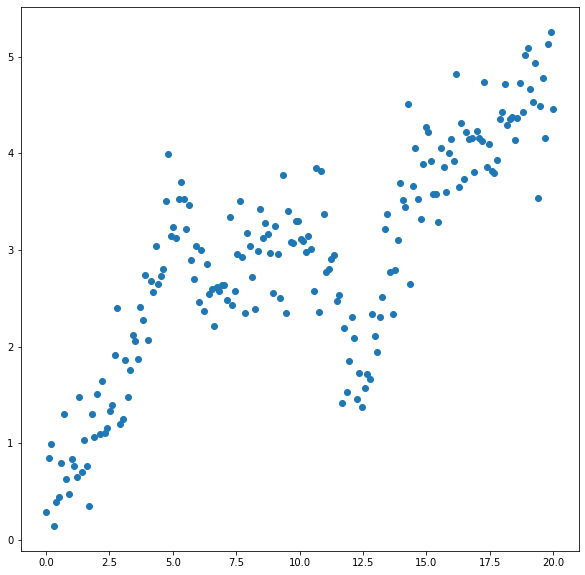

In [19]:
myData.show()

In [39]:
knn = knnr()
knn2 = knnr()

In [40]:
knn.fit(X,y)
knn2.fit(X,y)

In [41]:
y_hat = knn.predict(X, 40, epsilon = 1e-2)
y_hat2 = knn2.predict(X2, 14, epsilon = 1e-2)

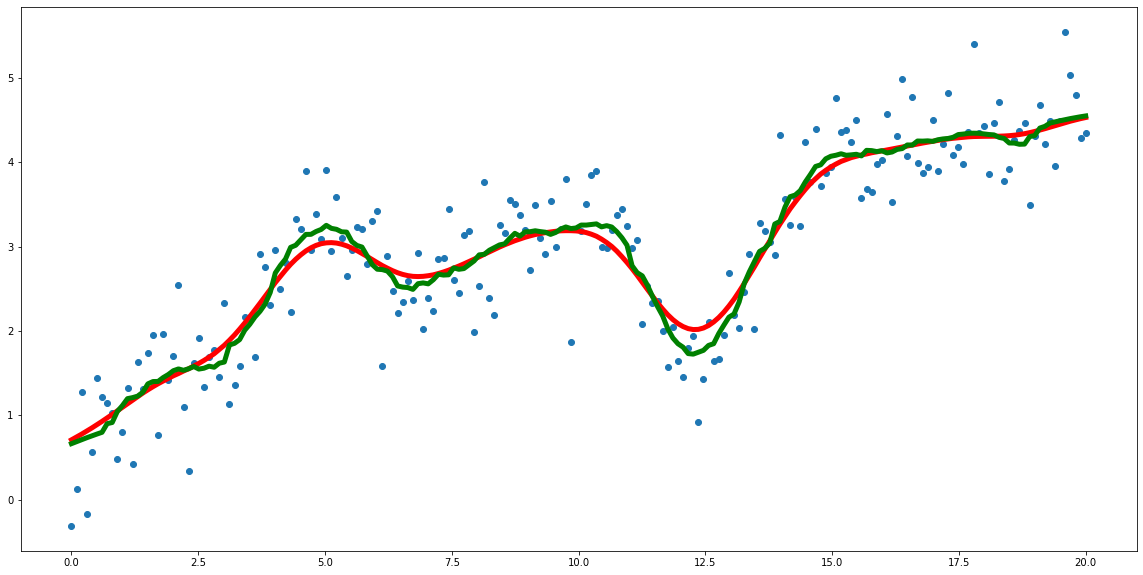

In [42]:
plt.figure(figsize =(20,10))
plt.scatter(X,y)

plt.plot(X,y_hat, color = 'red', linewidth = 5)
plt.plot(X2,y_hat2, color = 'green', linewidth=5)

In [43]:
y_hat = knn.predict(X, 14, epsilon = 1e-2)
y_hat2 = knn2.predict(X2, 14, epsilon = 1e-2)

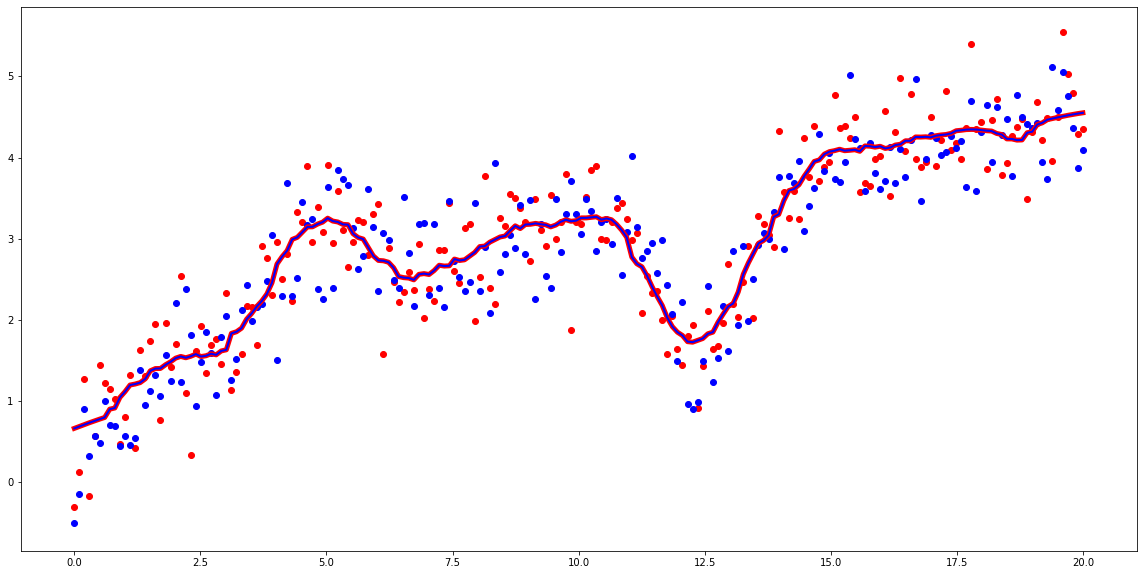

In [45]:
plt.figure(figsize =(20,10))
plt.scatter(X,y, color = 'red')
plt.scatter(X2,y2, color = 'blue')

plt.plot(X,y_hat, color = 'red', linewidth = 5)
plt.plot(X2,y_hat2, color = 'blue', linewidth=2)